# Half PQW profile generator

This is an example of usage for the module qncmbe.graded_alloys. Taken from growth G0646, which was a sequence of half-parabolic quantum wells.

In this file, we define an Al composition profile, calculate the required Al temperatures, calculate the Al input temperatures to compensate for the Al dynamics, and then generate the Molly code (.cmd files) required to grow the structure.

In [2]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from qncmbe.graded_alloys.AlGaAs_composition_control import Growth

import qncmbe.plotting as pltutils
pltutils.load_plot_style('qncmbe', update_style_files=False)

Installing/updating qncmbe plot styles...
Found qncmbe plot styles folder:
    "c:\users\chris\onedrive - university of waterloo\projects\isb polaritons\calculation tools\qncmbe\qncmbe\plot_stylelib"
Will installing plot styles:
    qncmbe-greyscale.mplstyle
    qncmbe-paper-aip.mplstyle
    qncmbe.mplstyle
Found existing local stylelib directory:
    "C:\Users\Chris\.matplotlib\stylelib"
Found existing local stylelib file "qncmbe-greyscale.mplstyle"
    Header check passed. Will update this file.
Found existing local stylelib file "qncmbe-paper-aip.mplstyle"
    Header check passed. Will update this file.
Found existing local stylelib file "qncmbe.mplstyle"
    Header check passed. Will update this file.
Installation complete. Reloading matplotlib library.


In [4]:
### Constants for Al cell

# Al static constants
A = 2.675e8 # K.Torr
B = 38696.34 # K
C = 4665.8 # (Å^-2.s^-1.Torr^-1.K^-1/2)

C *= 100 # Convert Å^-2 to nm^-2

# Al dynamics constants
K = 1.3410483125950972
t0 = 315.7468908840411
zeta = 0.6790177097187263

# Al shutter constants
K_sh = 4.7508397
t_sh = 454.88353185
zeta_sh = 0.59017545
T_sh = 0.86128655

# Combining them all into one dictionary
Al_cell_pars = {'static': [A,B,C],
                'shutter': [K_sh, t_sh, zeta_sh, T_sh],
                'dynamic': [K, t0, zeta]}

In [5]:

G_GaAs = 0.18
x_min = 0.02
x_max = 0.20

L_PQW = 81.28
L_bar = 60.0
N2D = 2.5e10

m_eff_min = (x_min*0.15 + (1 - x_min)*0.067)

f0 = 2*np.sqrt(847.91*(x_max - x_min)/(m_eff_min*6.651711e-3))/L_PQW*0.24180
print("Estimated PQW absorption frequency = {} THz".format(f0))

Ga_cell = 'Ga1'

growth = Growth(Ga_cell, G_GaAs, Al_cell_pars)

growth.add_half_PQW_step(
    name = 'Half PQW',
    L_QW = L_PQW, 
    x_min = x_min, 
    x_max = x_max, 
    Si_doped = True)

duration_PQW = growth.steps[-1].t[-1]




growth.add_smooth_ramp_step(
    name = 'Al ramping (stop growth)',
    duration = 60*3, 
    xi = x_min, 
    xf = x_max)

growth.add_smooth_ramp_step(
    name = 'Stabilize Al',
    duration = 60*4, 
    xi = x_max, 
    xf = x_max)

growth.add_AlGaAs_step(
    name = 'Barrier', 
    z = L_bar, 
    x = x_max)

print("")


print("For bulk-doped N = {:.4e} cm^-2, need flux {:.4e} cm^-2.s^-1 during PQW".format(N2D,N2D/duration_PQW))

T_bar = growth.steps[-1].T_Al[0]
print("Al barrier temperature: {:.1f} °C".format(T_bar - 273.15))

t = growth.get_t()
print("Total time = {:.2f} s = {:.2f} min".format(t[-1], t[-1]/60))

Estimated PQW absorption frequency = 3.439498646572497 THz
Adding step 'Half PQW'. Duration = 415.34 s
Adding step 'Al ramping (stop growth)'. Duration = 180.00 s
Adding step 'Stabilize Al'. Duration = 240.00 s
Adding step 'Barrier'. Duration = 266.52 s

For bulk-doped N = 2.5000e+10 cm^-2, need flux 6.0191e+07 cm^-2.s^-1 during PQW
Al barrier temperature: 1067.6 °C
Total time = 1101.86 s = 18.36 min


<IPython.core.display.Javascript object>


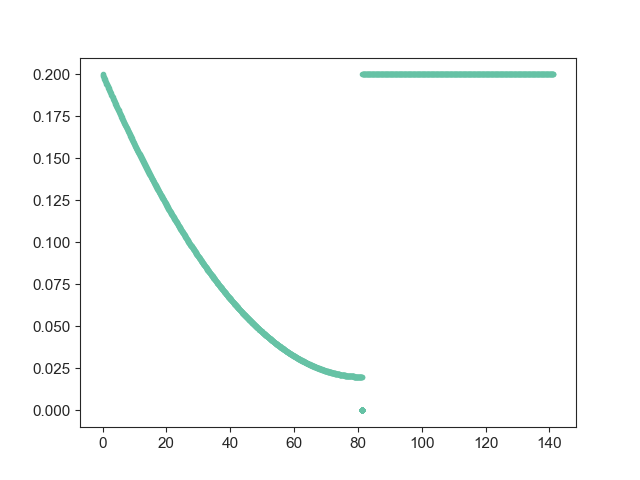

In [6]:
x = growth.get_Al_composition()
z = growth.get_cumulative_thickness()
t = growth.get_t()

fig, ax = plt.subplots()
ax.plot(z,x,'.')

<IPython.core.display.Javascript object>


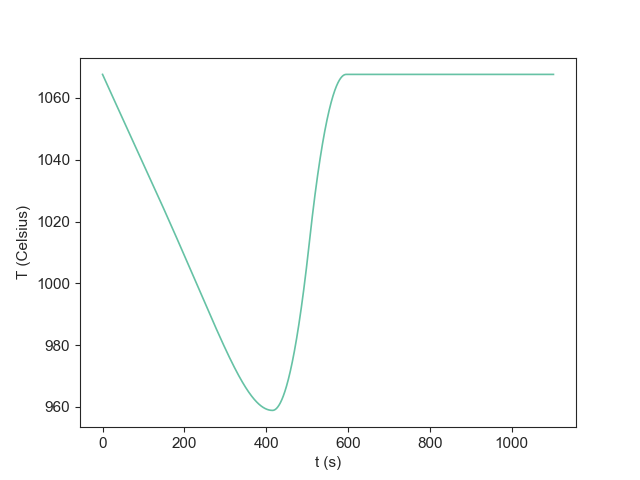

<IPython.core.display.Javascript object>


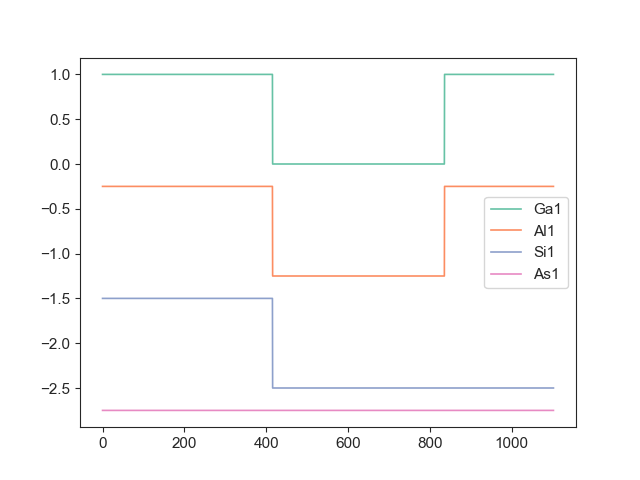

<IPython.core.display.Javascript object>


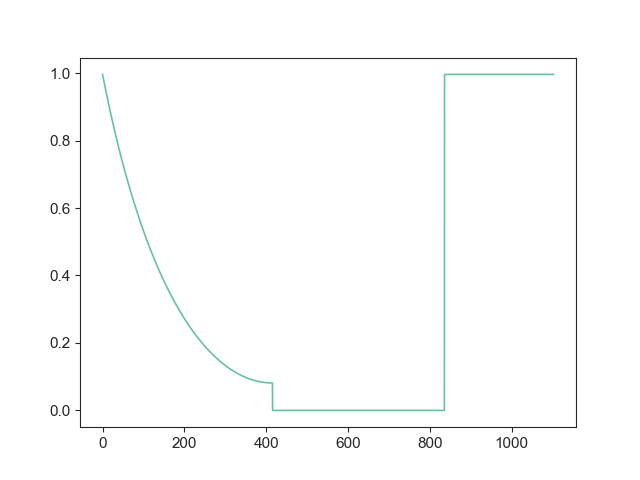

In [7]:
t = growth.get_t()

T = growth.get_T_Al()

fig, ax = plt.subplots()
ax.plot(t, T - 273.15)
ax.set_xlabel("t (s)")
ax.set_ylabel("T (Celsius)")

fig, ax = plt.subplots()
n = 0
for cell in [Ga_cell, 'Al1', 'Si1', 'As1']:
    s = growth.get_shutter_status(cell)
    ax.plot(t, s - 1.25*n, label = cell)
    n += 1

ax.legend()

fig, ax = plt.subplots()
flux = growth.get_Al_flux()
ax.plot(t, flux)

<IPython.core.display.Javascript object>


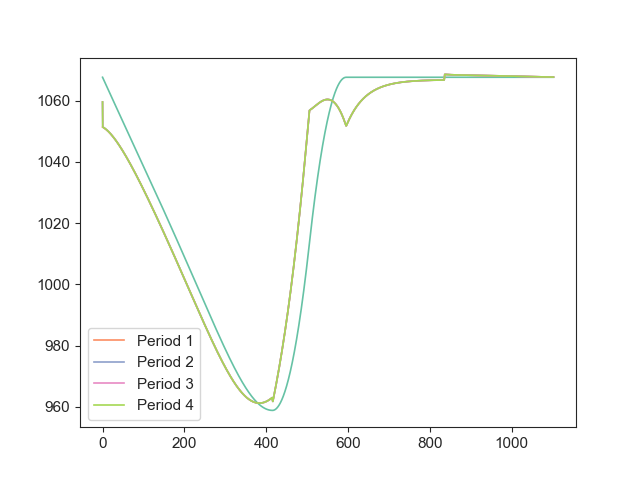

RMS change from period 1 --> 2: 1.752e-01 K
RMS change from period 2 --> 3: 2.956e-05 K
RMS change from period 3 --> 4: 4.618e-09 K


In [8]:
T_Al = growth.get_T_Al()
fig, ax = plt.subplots()
ax.plot(t, T_Al - 273.15)
T_in0 = growth.get_T_in(n_per = 1)
ax.plot(t, T_in0 - 273.15, label = "Period {}".format(1))
for n in range(3):
    T_in = growth.get_T_in(n_per = n + 2)
    
    print("RMS change from period {} --> {}: {:.3e} K".format(n+1, n+2,np.std(T_in - T_in0)))
    
    T_in0[:] = T_in[:]

    ax.plot(t, T_in - 273.15, label = "Period {}".format(n+2))
ax.legend()

In [9]:
growth_name = 'G0646'

for dry_run in [False, True]:

    for n in range(2):
        n_per = n+1

        code = growth.generate_Molly_code(dry_run = dry_run, n_per = n_per)

        fname = "{}_half_PQW_period_{}".format(growth_name,n_per)

        if dry_run: fname += "_dry_run"

        fname += ".cmd"

        with open(fname,'w') as file:
            file.write(code)

In [10]:
t = growth.get_t()
T_Al = growth.get_T_Al()
flux_Al = growth.get_Al_flux()
z = growth.get_cumulative_thickness()
s = growth.get_shutter_status('Al1')

out_arr = np.stack((t, T_Al, flux_Al, z, s), axis = 1)

header = 't (s), T_Al (K), flux_Al (nm^-2.s^-1), z (nm), x'

np.savetxt("Target_values.csv", out_arr, delimiter = ',', header = header)